# Nodule Segmentation: Model

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Configuration" data-toc-modified-id="Configuration-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Configuration</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Find-mean-of-images" data-toc-modified-id="Find-mean-of-images-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Find mean of images</a></span></li><li><span><a href="#Find-variance-of-images" data-toc-modified-id="Find-variance-of-images-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Find variance of images</a></span></li></ul></li><li><span><a href="#Data-Iterator" data-toc-modified-id="Data-Iterator-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Iterator</a></span></li><li><span><a href="#Evaluation-Metric" data-toc-modified-id="Evaluation-Metric-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Evaluation Metric</a></span></li><li><span><a href="#Model-Architecture" data-toc-modified-id="Model-Architecture-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model Architecture</a></span></li><li><span><a href="#Optimizer" data-toc-modified-id="Optimizer-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Optimizer</a></span><ul class="toc-item"><li><span><a href="#Find--learning-rate" data-toc-modified-id="Find--learning-rate-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Find  learning rate</a></span></li><li><span><a href="#Optimizer-Parameters" data-toc-modified-id="Optimizer-Parameters-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Optimizer Parameters</a></span></li></ul></li><li><span><a href="#Train-Model" data-toc-modified-id="Train-Model-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Train Model</a></span></li></ul></div>

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.insert(0,"./src")

In [3]:
import mynnet7 as nn
import pickle
import mxnet as mx
from imports import *

## Configuration

In [4]:
interm_dir4='/home/mas/x110/Datasets/Dataset5/' 
s = "2018_11_06"
train_data_path=interm_dir4+'processed/train'+s+'.rec'
train_idx_path=interm_dir4+'processed/train'+s+'.idx'
valid_data_path=interm_dir4+'processed/valid'+s+'.rec'
valid_idx_path=interm_dir4+'processed/valid'+s+'.idx'
test_data_path=interm_dir4+'processed/test'+s+'.rec'
test_idx_path=interm_dir4+'processed/test'+s+'.idx'

In [13]:
find_stats = False#True
bs = 34
load_model = False
model_path = "/home/mas/x110/model/nov10_2"
model_epoch=10
prefix = "/home/mas/x110/model/nov21"

In [14]:
epochs = 10

## Preprocessing

### Find mean of images

In [15]:
if find_stats:
    BATCH_SIZE=1
    train_iter=nn.FileIter(train_data_path,train_idx_path,batch_size=BATCH_SIZE,do_augment=True,mean_image=0,std_image=1)
    train_iter.reset()
    x_mean = np.zeros((32,32,32))
    for i,batch in enumerate(train_iter):
        X =  batch.data[0][0][0].asnumpy()
        x_mean+=X
    x_mean=np.mean(x_mean/i)
    # Saving the objects:
    with open(interm_dir4+'processed/x_mean.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([x_mean], f)

else:
    with open(interm_dir4+'processed/x_mean.pkl','rb') as f:  # Python 3: open(..., 'rb')
        x_mean = pickle.load(f)
x_mean#x_mean=0.2826227159416579

[0.2826227159416579]

In [16]:
x_mean=0.28

### Find variance of images

In [17]:
if find_stats: 
    BATCH_SIZE=1
    train_iter=nn.FileIter(train_data_path,train_idx_path,batch_size=BATCH_SIZE,do_augment=True,mean_image=0,std_image = 1)
    train_iter.reset()
    x_var = np.zeros((32,32,32))
    for i,batch in enumerate(train_iter):
        X =  (batch.data[0][0][0].asnumpy()-x_mean)**2
        x_var+=X
    #x_var=x_var/(i-1)
    #x_var#x_mean=.2815
    N = i*32*32*32
    x_var = np.sum(x_var)/(N-1)
    x_var#x_var = .07877
    x_std = np.sqrt(x_var)#x_std=.2807
    with open(interm_dir4+'processed/x_std.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([x_std], f)
else:
    with open(interm_dir4+'processed/x_std.pkl','rb') as f:  # Python 3: open(..., 'rb')
        x_std = pickle.load(f)
x_std#x_std=0.2817920662435274

[0.2817920662435274]

In [18]:
x_std = 0.28

## Data Iterator

In [19]:
BATCH_SIZE=bs
train_iter=nn.FileIter(train_data_path,train_idx_path,batch_size=BATCH_SIZE,random_flip=True,do_augment=False,mean_image=x_mean,std_image = x_std,do_shuffle=True)
input_shapes = dict(train_iter.provide_data+train_iter.provide_label)
print(input_shapes)

{'data': (34, 1, 32, 32, 32), 'softmax_label': (34, 32768)}


In [20]:
BATCH_SIZE=bs
valid_iter=nn.FileIter(valid_data_path,valid_idx_path,batch_size=BATCH_SIZE,do_augment=False,mean_image=x_mean,std_image = x_std,do_shuffle=False)

In [21]:
train_iter.reset()
valid_iter.reset()

## Evaluation Metric

In [22]:
def dice_coef2(label, y):
    smooth = 1.
    label=mx.nd.array(label).as_in_context(mx.gpu(0))
    y=mx.nd.array(y).as_in_context(mx.gpu(0))
    intersection = mx.nd.sum(label*y)
    return ((2. * intersection + smooth) / (mx.nd.sum(label) +mx.nd.sum(mx.nd.abs(y)) + smooth))


In [23]:
# ===============Evaluation metric(s)================= 
metric = mx.metric.CustomMetric(feval=nn.dice_coef2)

## Model Architecture

In [24]:
load_model

False

In [25]:
if load_model:
    network, arg_params, aux_params = mx.model.load_checkpoint(model_path , model_epoch)

    # Binding
    exe = network.simple_bind(ctx=mx.gpu(0), **input_shapes)


    exe.copy_params_from(arg_params, aux_params)
    
    # get handle to input arrays
    arg_arrays = dict(zip(network.list_arguments(), exe.arg_arrays))
    data = arg_arrays[train_iter.provide_data[0][0]]
    label = arg_arrays[train_iter.provide_label[0][0]]
else:

    network = nn.get_net_317()
    init = mx.init.Normal(0.01) #note biases and gamma/beta are not affected

    # Binding
    exe = network.simple_bind(ctx=mx.gpu(), **input_shapes)
    # get handle to input arrays
    arg_arrays = dict(zip(network.list_arguments(), exe.arg_arrays))
    data = arg_arrays[train_iter.provide_data[0][0]]
    label = arg_arrays[train_iter.provide_label[0][0]]
    for name, arr in arg_arrays.items():
        if name not in input_shapes:
            init(name, arr)


/home/mas/.virtualenvs/colab/lib/python3.5/site-packages/ipykernel_launcher.py:27: DeprecationWarning: Calling initializer with init(str, NDArray) has been deprecated.please use init(mx.init.InitDesc(...), NDArray) instead.


## Optimizer

### Find  learning rate

In [65]:
nb=train_iter.num_data//train_iter.batch_size
nb

92

In [66]:
train_iter.num_data

3154

In [67]:
sched=nn.lr_find(1e-4,nb,end_lr=.01)

In [68]:
# We also need to create an optimizer for updating weights
opt = mx.optimizer.SGD(
    learning_rate=.01,
    momentum=0.9,
    wd=0.00001,
    lr_scheduler=sched)

updater = mx.optimizer.get_updater(opt)

In [69]:
for epoch in range(0,1):

    start = time.time()

    metric.reset()

    train_iter.reset()
    
    valid_iter.reset()
    
    sched.reset()
        
    sched.on_train_begin()
    

    for batch in train_iter:
        # Copy data to executor input. Note the [:].
        data[:] = batch.data[0]
        label[:] = batch.label[0]

        # Forward
        outputs=exe.forward(is_train=True)
        # Backward
        exe.backward()

        # Update
        for i, pair in enumerate(zip(exe.arg_arrays, exe.grad_arrays)):
            weight, grad = pair
            updater(i, grad, weight)   
        metric.update(batch.label[0], exe.outputs[0])#metric.update(label,p)
        
        e=metric.get()
        err_train=-e[1].asnumpy()[0]
        sched.on_batch_end(err_train)
    
    if epoch % 100== 0:       
        #print("do_checkpoint")
        arg={k:v for k, v in arg_arrays.items() if k not in input_shapes}
        aux = dict(zip(network.list_auxiliary_states(), exe.aux_arrays))
        mx.model.save_checkpoint(prefix, epoch, network, arg, aux)
        
        
    #compute valid loss per epoch    
    metric.reset()
    for batch in valid_iter:        
        data[:] = batch.data[0]       
        label[:] = batch.label[0]
        # predict
        outputs = exe.forward(is_train=False)
        metric.update(batch.label[0], exe.outputs[0])
    e=metric.get()
    err_valid=-e[1].asnumpy()[0]
    end = time.time()
    print('time:',end-start,'Epoch:',epoch,'trainloss:',err_train,'validloss:',err_valid)

time: 1074.4015028476715 Epoch: 0 trainloss: -0.6313395 validloss: -0.59762365


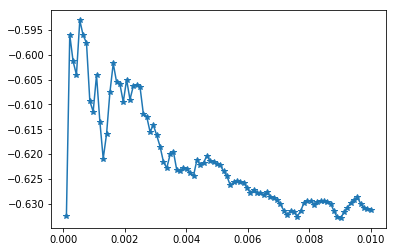

In [70]:
plt.plot(sched.lrs, sched.losses,'*-')

### Optimizer Parameters

In [73]:
# We also need to create an optimizer for updating weights
# ===============Optimizer=================                        
opt = mx.optimizer.SGD(
    learning_rate=.6,momentum=0.99,wd=0.000001)

In [74]:
updater = mx.optimizer.get_updater(opt)

In [75]:
updater.optimizer.lr_scheduler=None

## Train Model

In [44]:
Es_train=[]
for epoch in range(0,epochs+1):

    start = time.time()

    metric.reset()

    train_iter.reset()
    
    valid_iter.reset()
    

    for batch in train_iter:
        # Copy data to executor input. Note the [:].
        data[:] = batch.data[0]
        label[:] = batch.label[0]

        # Forward
        outputs=exe.forward(is_train=True)
        Es_train.append(outputs[1].asnumpy()[0])
        # Backward
        exe.backward()

        # Update
        for i, pair in enumerate(zip(exe.arg_arrays, exe.grad_arrays)):
            weight, grad = pair
            updater(i, grad, weight)   
        metric.update(batch.label[0], exe.outputs[0])#metric.update(label,p)
        
    e=metric.get()
    err_train=-e[1].asnumpy()[0]
    
    if epoch % 1== 0:       
        #print("do_checkpoint")
        arg={k:v for k, v in arg_arrays.items() if k not in input_shapes}
        aux = dict(zip(network.list_auxiliary_states(), exe.aux_arrays))
        mx.model.save_checkpoint(prefix, epoch, network, arg, aux)
        
        
    #compute valid loss per epoch    
    metric.reset()
    for batch in valid_iter:        
        data[:] = batch.data[0]       
        label[:] = batch.label[0]
        # predict
        outputs = exe.forward(is_train=False)
        metric.update(batch.label[0], exe.outputs[0])
    e=metric.get()
    err_valid=-e[1].asnumpy()[0]
    end = time.time()
    print('time:',end-start,'Epoch:',epoch,'trainloss:',err_train,'validloss:',err_valid)

time: 1014.9572851657867 Epoch: 0 trainloss: -0.5027871 validloss: -0.48457935
time: 963.1412189006805 Epoch: 1 trainloss: -0.5047942 validloss: -0.43496642
time: 976.4513416290283 Epoch: 2 trainloss: -0.5159327 validloss: -0.50842357
time: 963.5012400150299 Epoch: 3 trainloss: -0.51095587 validloss: -0.472452
time: 1011.2093727588654 Epoch: 4 trainloss: -0.53634274 validloss: -0.5102389
time: 1092.8659253120422 Epoch: 5 trainloss: -0.5398169 validloss: -0.5407242
time: 1120.021900177002 Epoch: 6 trainloss: -0.55297273 validloss: -0.3580525
time: 1089.1382081508636 Epoch: 7 trainloss: -0.576061 validloss: -0.5200018
time: 1009.4708251953125 Epoch: 8 trainloss: -0.56877416 validloss: -0.4873504
time: 1031.127200126648 Epoch: 9 trainloss: -0.5902908 validloss: -0.52528375
time: 1056.9749131202698 Epoch: 10 trainloss: -0.59381497 validloss: -0.54680634


In [59]:
# We also need to create an optimizer for updating weights
# ===============Optimizer=================                        
opt = mx.optimizer.SGD(
    learning_rate=.002,momentum=0.99,wd=0.000001)
updater = mx.optimizer.get_updater(opt)
updater.optimizer.lr_scheduler=None

In [60]:
Es_train=[]
for epoch in range(10,10+epochs+1):

    start = time.time()

    metric.reset()

    train_iter.reset()
    
    valid_iter.reset()
    

    for batch in train_iter:
        # Copy data to executor input. Note the [:].
        data[:] = batch.data[0]
        label[:] = batch.label[0]

        # Forward
        outputs=exe.forward(is_train=True)
        Es_train.append(outputs[1].asnumpy()[0])
        # Backward
        exe.backward()

        # Update
        for i, pair in enumerate(zip(exe.arg_arrays, exe.grad_arrays)):
            weight, grad = pair
            updater(i, grad, weight)   
        metric.update(batch.label[0], exe.outputs[0])#metric.update(label,p)
        
    e=metric.get()
    err_train=-e[1].asnumpy()[0]
    
    if epoch % 1== 0:       
        #print("do_checkpoint")
        arg={k:v for k, v in arg_arrays.items() if k not in input_shapes}
        aux = dict(zip(network.list_auxiliary_states(), exe.aux_arrays))
        mx.model.save_checkpoint(prefix, epoch, network, arg, aux)
        
        
    #compute valid loss per epoch    
    metric.reset()
    for batch in valid_iter:        
        data[:] = batch.data[0]       
        label[:] = batch.label[0]
        # predict
        outputs = exe.forward(is_train=False)
        metric.update(batch.label[0], exe.outputs[0])
    e=metric.get()
    err_valid=-e[1].asnumpy()[0]
    end = time.time()
    print('time:',end-start,'Epoch:',epoch,'trainloss:',err_train,'validloss:',err_valid)

time: 1032.1247651576996 Epoch: 10 trainloss: -0.6262612 validloss: -0.59434366
time: 1015.4967386722565 Epoch: 11 trainloss: -0.6246276 validloss: -0.5977376
time: 964.3362245559692 Epoch: 12 trainloss: -0.6252805 validloss: -0.5979749
time: 965.4722592830658 Epoch: 13 trainloss: -0.6272431 validloss: -0.5948525
time: 963.3954541683197 Epoch: 14 trainloss: -0.63004446 validloss: -0.596977
time: 962.9875009059906 Epoch: 15 trainloss: -0.63573116 validloss: -0.59614986
time: 963.1726186275482 Epoch: 16 trainloss: -0.6252429 validloss: -0.59677386
time: 970.7753040790558 Epoch: 17 trainloss: -0.6333995 validloss: -0.59722483
time: 962.9862439632416 Epoch: 18 trainloss: -0.63056296 validloss: -0.598578
time: 963.3282463550568 Epoch: 19 trainloss: -0.6267774 validloss: -0.5983301
time: 965.908561706543 Epoch: 20 trainloss: -0.6258145 validloss: -0.59774524


In [76]:
Es_train=[]
for epoch in range(21,20+epochs+1):

    start = time.time()

    metric.reset()

    train_iter.reset()
    
    valid_iter.reset()
    

    for batch in train_iter:
        # Copy data to executor input. Note the [:].
        data[:] = batch.data[0]
        label[:] = batch.label[0]

        # Forward
        outputs=exe.forward(is_train=True)
        Es_train.append(outputs[1].asnumpy()[0])
        # Backward
        exe.backward()

        # Update
        for i, pair in enumerate(zip(exe.arg_arrays, exe.grad_arrays)):
            weight, grad = pair
            updater(i, grad, weight)   
        metric.update(batch.label[0], exe.outputs[0])#metric.update(label,p)
        
    e=metric.get()
    err_train=-e[1].asnumpy()[0]
    
    if epoch % 1== 0:       
        #print("do_checkpoint")
        arg={k:v for k, v in arg_arrays.items() if k not in input_shapes}
        aux = dict(zip(network.list_auxiliary_states(), exe.aux_arrays))
        mx.model.save_checkpoint(prefix, epoch, network, arg, aux)
        
        
    #compute valid loss per epoch    
    metric.reset()
    for batch in valid_iter:        
        data[:] = batch.data[0]       
        label[:] = batch.label[0]
        # predict
        outputs = exe.forward(is_train=False)
        metric.update(batch.label[0], exe.outputs[0])
    e=metric.get()
    err_valid=-e[1].asnumpy()[0]
    end = time.time()
    print('time:',end-start,'Epoch:',epoch,'trainloss:',err_train,'validloss:',err_valid)

time: 963.6896002292633 Epoch: 21 trainloss: -0.63617826 validloss: -0.59780663
time: 971.8709495067596 Epoch: 22 trainloss: -0.637104 validloss: -0.5971514
time: 964.8209009170532 Epoch: 23 trainloss: -0.6285482 validloss: -0.5985175
time: 967.4705202579498 Epoch: 24 trainloss: -0.64037 validloss: -0.5992347
time: 1109.499277830124 Epoch: 25 trainloss: -0.630544 validloss: -0.6005427
time: 982.2282490730286 Epoch: 26 trainloss: -0.63734496 validloss: -0.59976065
time: 963.4783351421356 Epoch: 27 trainloss: -0.6373183 validloss: -0.6003545
time: 962.9469068050385 Epoch: 28 trainloss: -0.63562196 validloss: -0.60007924
time: 970.8003466129303 Epoch: 29 trainloss: -0.6340345 validloss: -0.5990174
time: 963.0016982555389 Epoch: 30 trainloss: -0.6369357 validloss: -0.6005741


time: 967.1313564777374 Epoch: 0 trainloss: -0.6409506 validloss: -0.60108876


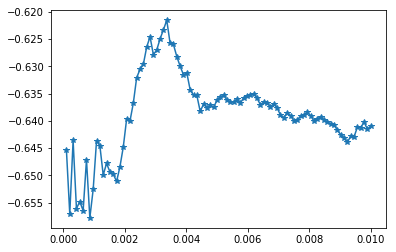

In [77]:
sched=nn.lr_find(1e-4,nb,end_lr=.01)
# We also need to create an optimizer for updating weights
opt = mx.optimizer.SGD(
    learning_rate=.01,
    momentum=0.9,
    wd=0.00001,
    lr_scheduler=sched)

updater = mx.optimizer.get_updater(opt)
for epoch in range(0,1):

    start = time.time()

    metric.reset()

    train_iter.reset()
    
    valid_iter.reset()
    
    sched.reset()
        
    sched.on_train_begin()
    

    for batch in train_iter:
        # Copy data to executor input. Note the [:].
        data[:] = batch.data[0]
        label[:] = batch.label[0]

        # Forward
        outputs=exe.forward(is_train=True)
        # Backward
        exe.backward()

        # Update
        for i, pair in enumerate(zip(exe.arg_arrays, exe.grad_arrays)):
            weight, grad = pair
            updater(i, grad, weight)   
        metric.update(batch.label[0], exe.outputs[0])#metric.update(label,p)
        
        e=metric.get()
        err_train=-e[1].asnumpy()[0]
        sched.on_batch_end(err_train)
    
    if epoch % 100== 0:       
        #print("do_checkpoint")
        arg={k:v for k, v in arg_arrays.items() if k not in input_shapes}
        aux = dict(zip(network.list_auxiliary_states(), exe.aux_arrays))
        mx.model.save_checkpoint(prefix, epoch, network, arg, aux)
        
        
    #compute valid loss per epoch    
    metric.reset()
    for batch in valid_iter:        
        data[:] = batch.data[0]       
        label[:] = batch.label[0]
        # predict
        outputs = exe.forward(is_train=False)
        metric.update(batch.label[0], exe.outputs[0])
    e=metric.get()
    err_valid=-e[1].asnumpy()[0]
    end = time.time()
    print('time:',end-start,'Epoch:',epoch,'trainloss:',err_train,'validloss:',err_valid)
plt.plot(sched.lrs, sched.losses,'*-')

In [79]:
# We also need to create an optimizer for updating weights
# ===============Optimizer=================                        
opt = mx.optimizer.SGD(
    learning_rate=.0002,momentum=0.99,wd=0.000001)
updater = mx.optimizer.get_updater(opt)
updater.optimizer.lr_scheduler=None

Es_train=[]
for epoch in range(31,30+epochs+1):

    start = time.time()

    metric.reset()

    train_iter.reset()
    
    valid_iter.reset()
    

    for batch in train_iter:
        # Copy data to executor input. Note the [:].
        data[:] = batch.data[0]
        label[:] = batch.label[0]

        # Forward
        outputs=exe.forward(is_train=True)
        Es_train.append(outputs[1].asnumpy()[0])
        # Backward
        exe.backward()

        # Update
        for i, pair in enumerate(zip(exe.arg_arrays, exe.grad_arrays)):
            weight, grad = pair
            updater(i, grad, weight)   
        metric.update(batch.label[0], exe.outputs[0])#metric.update(label,p)
        
    e=metric.get()
    err_train=-e[1].asnumpy()[0]
    
    if epoch % 1== 0:       
        #print("do_checkpoint")
        arg={k:v for k, v in arg_arrays.items() if k not in input_shapes}
        aux = dict(zip(network.list_auxiliary_states(), exe.aux_arrays))
        mx.model.save_checkpoint(prefix, epoch, network, arg, aux)
        
        
    #compute valid loss per epoch    
    metric.reset()
    for batch in valid_iter:        
        data[:] = batch.data[0]       
        label[:] = batch.label[0]
        # predict
        outputs = exe.forward(is_train=False)
        metric.update(batch.label[0], exe.outputs[0])
    e=metric.get()
    err_valid=-e[1].asnumpy()[0]
    end = time.time()
    print('time:',end-start,'Epoch:',epoch,'trainloss:',err_train,'validloss:',err_valid)

time: 967.310497045517 Epoch: 0 trainloss: -0.642568 validloss: -0.6020861


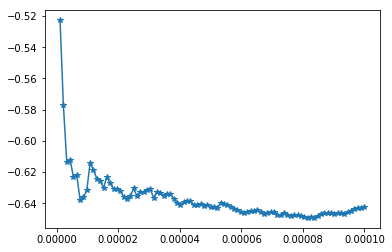

In [84]:
sched=nn.lr_find(1e-5,nb,end_lr=1e-4)
# We also need to create an optimizer for updating weights
opt = mx.optimizer.SGD(
    learning_rate=.01,
    momentum=0.9,
    wd=0.00001,
    lr_scheduler=sched)

updater = mx.optimizer.get_updater(opt)
for epoch in range(0,1):

    start = time.time()

    metric.reset()

    train_iter.reset()
    
    valid_iter.reset()
    
    sched.reset()
        
    sched.on_train_begin()
    

    for batch in train_iter:
        # Copy data to executor input. Note the [:].
        data[:] = batch.data[0]
        label[:] = batch.label[0]

        # Forward
        outputs=exe.forward(is_train=True)
        # Backward
        exe.backward()

        # Update
        for i, pair in enumerate(zip(exe.arg_arrays, exe.grad_arrays)):
            weight, grad = pair
            updater(i, grad, weight)   
        metric.update(batch.label[0], exe.outputs[0])#metric.update(label,p)
        
        e=metric.get()
        err_train=-e[1].asnumpy()[0]
        sched.on_batch_end(err_train)
    
    if epoch % 100== 0:       
        #print("do_checkpoint")
        arg={k:v for k, v in arg_arrays.items() if k not in input_shapes}
        aux = dict(zip(network.list_auxiliary_states(), exe.aux_arrays))
        mx.model.save_checkpoint(prefix, epoch, network, arg, aux)
        
        
    #compute valid loss per epoch    
    metric.reset()
    for batch in valid_iter:        
        data[:] = batch.data[0]       
        label[:] = batch.label[0]
        # predict
        outputs = exe.forward(is_train=False)
        metric.update(batch.label[0], exe.outputs[0])
    e=metric.get()
    err_valid=-e[1].asnumpy()[0]
    end = time.time()
    print('time:',end-start,'Epoch:',epoch,'trainloss:',err_train,'validloss:',err_valid)
plt.plot(sched.lrs, sched.losses,'*-')

In [85]:
# We also need to create an optimizer for updating weights
# ===============Optimizer=================                        
opt = mx.optimizer.SGD(
    learning_rate=.0001,momentum=0.99,wd=0.000001)
updater = mx.optimizer.get_updater(opt)
updater.optimizer.lr_scheduler=None

Es_train=[]
for epoch in range(31,30+epochs+1):

    start = time.time()

    metric.reset()

    train_iter.reset()
    
    valid_iter.reset()
    

    for batch in train_iter:
        # Copy data to executor input. Note the [:].
        data[:] = batch.data[0]
        label[:] = batch.label[0]

        # Forward
        outputs=exe.forward(is_train=True)
        Es_train.append(outputs[1].asnumpy()[0])
        # Backward
        exe.backward()

        # Update
        for i, pair in enumerate(zip(exe.arg_arrays, exe.grad_arrays)):
            weight, grad = pair
            updater(i, grad, weight)   
        metric.update(batch.label[0], exe.outputs[0])#metric.update(label,p)
        
    e=metric.get()
    err_train=-e[1].asnumpy()[0]
    
    if epoch % 1== 0:       
        #print("do_checkpoint")
        arg={k:v for k, v in arg_arrays.items() if k not in input_shapes}
        aux = dict(zip(network.list_auxiliary_states(), exe.aux_arrays))
        mx.model.save_checkpoint(prefix, epoch, network, arg, aux)
        
        
    #compute valid loss per epoch    
    metric.reset()
    for batch in valid_iter:        
        data[:] = batch.data[0]       
        label[:] = batch.label[0]
        # predict
        outputs = exe.forward(is_train=False)
        metric.update(batch.label[0], exe.outputs[0])
    e=metric.get()
    err_valid=-e[1].asnumpy()[0]
    end = time.time()
    print('time:',end-start,'Epoch:',epoch,'trainloss:',err_train,'validloss:',err_valid)

time: 1029.70050406456 Epoch: 31 trainloss: -0.6375434 validloss: -0.6015689
time: 963.1116187572479 Epoch: 32 trainloss: -0.6447369 validloss: -0.6010424
time: 1001.5188176631927 Epoch: 33 trainloss: -0.6373317 validloss: -0.6028467
time: 1042.5987355709076 Epoch: 34 trainloss: -0.6376999 validloss: -0.60154295
time: 1118.726527929306 Epoch: 35 trainloss: -0.6399328 validloss: -0.60232586
time: 1128.7740921974182 Epoch: 36 trainloss: -0.6403759 validloss: -0.60116565
time: 963.4591181278229 Epoch: 37 trainloss: -0.63942456 validloss: -0.59994036
time: 963.4513881206512 Epoch: 38 trainloss: -0.6350481 validloss: -0.60172105
time: 963.4448976516724 Epoch: 39 trainloss: -0.6379368 validloss: -0.60087115
time: 971.3469970226288 Epoch: 40 trainloss: -0.63868695 validloss: -0.60153395


time: 1011.2775242328644 Epoch: 0 trainloss: -0.6421564 validloss: -0.5995838


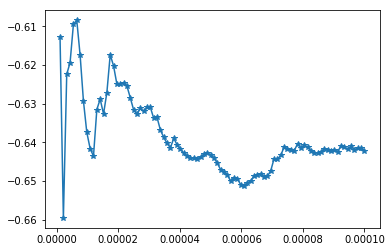

In [89]:
sched=nn.lr_find(1e-6,nb,end_lr=1e-4)
# We also need to create an optimizer for updating weights
opt = mx.optimizer.SGD(
    learning_rate=.01,
    momentum=0.9,
    wd=0.00001,
    lr_scheduler=sched)

updater = mx.optimizer.get_updater(opt)
for epoch in range(0,1):

    start = time.time()

    metric.reset()

    train_iter.reset()
    
    valid_iter.reset()
    
    sched.reset()
        
    sched.on_train_begin()
    

    for batch in train_iter:
        # Copy data to executor input. Note the [:].
        data[:] = batch.data[0]
        label[:] = batch.label[0]

        # Forward
        outputs=exe.forward(is_train=True)
        # Backward
        exe.backward()

        # Update
        for i, pair in enumerate(zip(exe.arg_arrays, exe.grad_arrays)):
            weight, grad = pair
            updater(i, grad, weight)   
        metric.update(batch.label[0], exe.outputs[0])#metric.update(label,p)
        
        e=metric.get()
        err_train=-e[1].asnumpy()[0]
        sched.on_batch_end(err_train)
    
    if epoch % 100== 0:       
        #print("do_checkpoint")
        arg={k:v for k, v in arg_arrays.items() if k not in input_shapes}
        aux = dict(zip(network.list_auxiliary_states(), exe.aux_arrays))
        mx.model.save_checkpoint(prefix, epoch, network, arg, aux)
        
        
    #compute valid loss per epoch    
    metric.reset()
    for batch in valid_iter:        
        data[:] = batch.data[0]       
        label[:] = batch.label[0]
        # predict
        outputs = exe.forward(is_train=False)
        metric.update(batch.label[0], exe.outputs[0])
    e=metric.get()
    err_valid=-e[1].asnumpy()[0]
    end = time.time()
    print('time:',end-start,'Epoch:',epoch,'trainloss:',err_train,'validloss:',err_valid)
plt.plot(sched.lrs, sched.losses,'*-')

In [90]:
# We also need to create an optimizer for updating weights
# ===============Optimizer=================                        
opt = mx.optimizer.SGD(
    learning_rate=.00001,momentum=0.99,wd=0.000001)
updater = mx.optimizer.get_updater(opt)
updater.optimizer.lr_scheduler=None

Es_train=[]
for epoch in range(31,30+epochs+1):

    start = time.time()

    metric.reset()

    train_iter.reset()
    
    valid_iter.reset()
    

    for batch in train_iter:
        # Copy data to executor input. Note the [:].
        data[:] = batch.data[0]
        label[:] = batch.label[0]

        # Forward
        outputs=exe.forward(is_train=True)
        Es_train.append(outputs[1].asnumpy()[0])
        # Backward
        exe.backward()

        # Update
        for i, pair in enumerate(zip(exe.arg_arrays, exe.grad_arrays)):
            weight, grad = pair
            updater(i, grad, weight)   
        metric.update(batch.label[0], exe.outputs[0])#metric.update(label,p)
        
    e=metric.get()
    err_train=-e[1].asnumpy()[0]
    
    if epoch % 1== 0:       
        #print("do_checkpoint")
        arg={k:v for k, v in arg_arrays.items() if k not in input_shapes}
        aux = dict(zip(network.list_auxiliary_states(), exe.aux_arrays))
        mx.model.save_checkpoint(prefix, epoch, network, arg, aux)
        
        
    #compute valid loss per epoch    
    metric.reset()
    for batch in valid_iter:        
        data[:] = batch.data[0]       
        label[:] = batch.label[0]
        # predict
        outputs = exe.forward(is_train=False)
        metric.update(batch.label[0], exe.outputs[0])
    e=metric.get()
    err_valid=-e[1].asnumpy()[0]
    end = time.time()
    print('time:',end-start,'Epoch:',epoch,'trainloss:',err_train,'validloss:',err_valid)

time: 963.4726159572601 Epoch: 31 trainloss: -0.6341187 validloss: -0.60025764
time: 963.427638053894 Epoch: 32 trainloss: -0.6366444 validloss: -0.60218316
time: 963.4259030818939 Epoch: 33 trainloss: -0.6365374 validloss: -0.6016662
time: 964.5153124332428 Epoch: 34 trainloss: -0.6380442 validloss: -0.6022558
time: 963.4052646160126 Epoch: 35 trainloss: -0.6389481 validloss: -0.6007436
time: 963.4025971889496 Epoch: 36 trainloss: -0.6383177 validloss: -0.5987216
time: 963.4005007743835 Epoch: 37 trainloss: -0.6399127 validloss: -0.6015768
time: 971.1120665073395 Epoch: 38 trainloss: -0.6341015 validloss: -0.6021046
time: 964.1920278072357 Epoch: 39 trainloss: -0.6392297 validloss: -0.60192454
time: 963.2340085506439 Epoch: 40 trainloss: -0.63549334 validloss: -0.60124


time: 997.5361273288727 Epoch: 0 trainloss: -0.63789845 validloss: -0.601


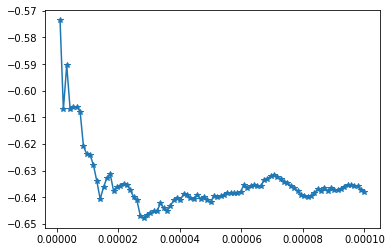

In [91]:
sched=nn.lr_find(1e-6,nb,end_lr=1e-4)
# We also need to create an optimizer for updating weights
opt = mx.optimizer.SGD(
    learning_rate=.01,
    momentum=0.9,
    wd=0.00001,
    lr_scheduler=sched)

updater = mx.optimizer.get_updater(opt)
for epoch in range(0,1):

    start = time.time()

    metric.reset()

    train_iter.reset()
    
    valid_iter.reset()
    
    sched.reset()
        
    sched.on_train_begin()
    

    for batch in train_iter:
        # Copy data to executor input. Note the [:].
        data[:] = batch.data[0]
        label[:] = batch.label[0]

        # Forward
        outputs=exe.forward(is_train=True)
        # Backward
        exe.backward()

        # Update
        for i, pair in enumerate(zip(exe.arg_arrays, exe.grad_arrays)):
            weight, grad = pair
            updater(i, grad, weight)   
        metric.update(batch.label[0], exe.outputs[0])#metric.update(label,p)
        
        e=metric.get()
        err_train=-e[1].asnumpy()[0]
        sched.on_batch_end(err_train)
    
    if epoch % 100== 0:       
        #print("do_checkpoint")
        arg={k:v for k, v in arg_arrays.items() if k not in input_shapes}
        aux = dict(zip(network.list_auxiliary_states(), exe.aux_arrays))
        mx.model.save_checkpoint(prefix, epoch, network, arg, aux)
        
        
    #compute valid loss per epoch    
    metric.reset()
    for batch in valid_iter:        
        data[:] = batch.data[0]       
        label[:] = batch.label[0]
        # predict
        outputs = exe.forward(is_train=False)
        metric.update(batch.label[0], exe.outputs[0])
    e=metric.get()
    err_valid=-e[1].asnumpy()[0]
    end = time.time()
    print('time:',end-start,'Epoch:',epoch,'trainloss:',err_train,'validloss:',err_valid)
plt.plot(sched.lrs, sched.losses,'*-')

In [96]:
sched.lrs[9]

1.0869565217391307e-05

In [97]:
epochs=20

In [102]:
# We also need to create an optimizer for updating weights
# ===============Optimizer=================                        
opt = mx.optimizer.SGD(
    learning_rate=1.08e-5,momentum=0.99,wd=0.000001)
updater = mx.optimizer.get_updater(opt)
updater.optimizer.lr_scheduler=None

Es_train=[]
for epoch in range(41,40+epochs+1):

    start = time.time()

    metric.reset()

    train_iter.reset()
    
    valid_iter.reset()
    

    for batch in train_iter:
        # Copy data to executor input. Note the [:].
        data[:] = batch.data[0]
        label[:] = batch.label[0]

        # Forward
        outputs=exe.forward(is_train=True)
        Es_train.append(outputs[1].asnumpy()[0])
        # Backward
        exe.backward()

        # Update
        for i, pair in enumerate(zip(exe.arg_arrays, exe.grad_arrays)):
            weight, grad = pair
            updater(i, grad, weight)   
        metric.update(batch.label[0], exe.outputs[0])#metric.update(label,p)
        
    e=metric.get()
    err_train=-e[1].asnumpy()[0]
    
    if epoch % 1== 0:       
        #print("do_checkpoint")
        arg={k:v for k, v in arg_arrays.items() if k not in input_shapes}
        aux = dict(zip(network.list_auxiliary_states(), exe.aux_arrays))
        mx.model.save_checkpoint(prefix, epoch, network, arg, aux)
        
        
    #compute valid loss per epoch    
    metric.reset()
    for batch in valid_iter:        
        data[:] = batch.data[0]       
        label[:] = batch.label[0]
        # predict
        outputs = exe.forward(is_train=False)
        metric.update(batch.label[0], exe.outputs[0])
    e=metric.get()
    err_valid=-e[1].asnumpy()[0]
    end = time.time()
    print('time:',end-start,'Epoch:',epoch,'trainloss:',err_train,'validloss:',err_valid)

time: 965.926069021225 Epoch: 41 trainloss: -0.6417016 validloss: -0.6009746
time: 966.439649105072 Epoch: 42 trainloss: -0.6369442 validloss: -0.60043335
time: 965.8999509811401 Epoch: 43 trainloss: -0.6358517 validloss: -0.60229665
time: 966.376193523407 Epoch: 44 trainloss: -0.6339192 validloss: -0.6006534
time: 965.7028660774231 Epoch: 45 trainloss: -0.6397999 validloss: -0.60219663
time: 965.7540953159332 Epoch: 46 trainloss: -0.6338651 validloss: -0.6025624
time: 966.3226459026337 Epoch: 47 trainloss: -0.6346202 validloss: -0.60028845
time: 965.9185349941254 Epoch: 48 trainloss: -0.6369934 validloss: -0.59892905
time: 966.2536473274231 Epoch: 49 trainloss: -0.63621587 validloss: -0.60141414
time: 970.2478709220886 Epoch: 50 trainloss: -0.63258237 validloss: -0.6023066
time: 964.3262436389923 Epoch: 51 trainloss: -0.63033545 validloss: -0.5984501
time: 963.9996881484985 Epoch: 52 trainloss: -0.642814 validloss: -0.60033566
time: 963.9304773807526 Epoch: 53 trainloss: -0.6431664 va